<a href="https://colab.research.google.com/github/jasleenkaursandhu/Reproducing-chest-xray-report-generation-boag/blob/main/chexpert_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
# Define paths
# base_path = '/Volumes/DATA/DATASET/untitled/content/mimic-cxr-project/' # For local machine
# base_path = '/content/drive/MyDrive/mimic-cxr-project' # For Google Colab

In [27]:
# docker_image_name = 'uwizeye2/chexpert-labeler:amd64'
# !docker run --platform linux/amd64 -v {base_path}output:/data {docker_image_name} python label.py --reports_path /data/reference_headerless.csv --output_path /data/labeled_reference.csv --verbose

In [28]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, accuracy_score
import os
from time import strftime, gmtime

In [29]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define paths
base_path = '/content/drive/MyDrive/mimic-cxr-project'
output_dir = os.path.join(base_path, 'local_output/output')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
# Load labeled files
print("Loading labeled files...")
reference_df = pd.read_csv(os.path.join(output_dir, 'labeled_reference.csv'))
random_df = pd.read_csv(os.path.join(output_dir, 'labeled_random.csv'))
onegram_df = pd.read_csv(os.path.join(output_dir, 'labeled_1-gram.csv'))
twogram_df = pd.read_csv(os.path.join(output_dir, 'labeled_2-gram.csv'))
threegram_df = pd.read_csv(os.path.join(output_dir, 'labeled_3-gram.csv'))
knn_df = pd.read_csv(os.path.join(output_dir, 'labeled_knn.csv'))

print(f"Reference shape: {reference_df.shape}")
print(f"Random shape: {random_df.shape}")
print(f"1-gram shape: {onegram_df.shape}")
print(f"2-gram shape: {twogram_df.shape}")
print(f"3-gram shape: {threegram_df.shape}")
print(f"KNN shape: {knn_df.shape}")

Loading labeled files...
Reference shape: (1757, 15)
Random shape: (1757, 15)
1-gram shape: (1717, 15)
2-gram shape: (1757, 15)
3-gram shape: (1757, 15)
KNN shape: (1757, 15)


In [31]:
# Get all the categories (columns) except the 'Reports' column
categories = [col for col in reference_df.columns if col != 'Reports']
print(f"\nCategories: {categories}")


Categories: ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Lesion', 'Lung Opacity', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']


In [32]:
# Define evaluation function with sample matching
def calculate_metrics(true_df, pred_df):
    # Find common indices
    common_indices = true_df.index.intersection(pred_df.index)
    if len(common_indices) == 0:
        # If no common indices found by index, try matching by report text
        if 'Reports' in true_df.columns and 'Reports' in pred_df.columns:
            # Create dictionaries mapping reports to their rows
            true_reports = {report: i for i, report in enumerate(true_df['Reports'].values)}
            pred_reports = {report: i for i, report in enumerate(pred_df['Reports'].values)}
            # Find common reports
            common_reports = set(true_reports.keys()).intersection(set(pred_reports.keys()))
            if common_reports:
                print(f"Found {len(common_reports)} common reports by text matching")
                # Extract rows with common reports
                true_subset = true_df.loc[[true_reports[report] for report in common_reports]]
                pred_subset = pred_df.loc[[pred_reports[report] for report in common_reports]]
            else:
                # No matching by text either, try using the first rows
                print("No common samples found. Using first min(len1, len2) rows.")
                min_rows = min(len(true_df), len(pred_df))
                true_subset = true_df.iloc[:min_rows]
                pred_subset = pred_df.iloc[:min_rows]
        else:
            # No reports column, try matching row by row
            print("No common indices found. Using first min(len1, len2) rows.")
            min_rows = min(len(true_df), len(pred_df))
            true_subset = true_df.iloc[:min_rows]
            pred_subset = pred_df.iloc[:min_rows]
    else:
        print(f"Found {len(common_indices)} common indices")
        true_subset = true_df.loc[common_indices]
        pred_subset = pred_df.loc[common_indices]

    # Ensure all categories exist in both dataframes
    eval_categories = [col for col in categories if col in true_subset.columns and col in pred_subset.columns]

    # Fill missing values with -2 (not mentioned)
    true_subset = true_subset[eval_categories].fillna(-2)
    pred_subset = pred_subset[eval_categories].fillna(-2)

    # For accuracy: Calculate per-category accuracy
    accuracies = {}
    for category in eval_categories:
        accuracy = accuracy_score(true_subset[category], pred_subset[category])
        accuracies[category] = accuracy

    # For precision: Calculate per-category precision (for positive class only)
    true_binary = (true_subset == 1).astype(int)
    pred_binary = (pred_subset == 1).astype(int)

    precisions = {}
    for category in eval_categories:
        if sum(pred_binary[category]) > 0:  # Only if there are predicted positives
            precision = precision_score(true_binary[category], pred_binary[category], zero_division=0)
            precisions[category] = precision
        else:
            precisions[category] = 0.0

    # For F1: Calculate per-category F1
    f1_scores = {}
    for category in eval_categories:
        f1 = f1_score(true_binary[category], pred_binary[category], zero_division=0)
        f1_scores[category] = f1

    # Calculate macro averages
    macro_accuracy = np.mean(list(accuracies.values()))
    macro_precision = np.mean(list(precisions.values()))
    macro_f1 = np.mean(list(f1_scores.values()))

    # Calculate micro averages (overall)
    micro_f1 = f1_score(true_binary.values.flatten(), pred_binary.values.flatten(), zero_division=0)

    # Return all metrics
    return {
        'category_f1': f1_scores,
        'category_precision': precisions,
        'category_accuracy': accuracies,
        'macro_accuracy': macro_accuracy,
        'macro_precision': macro_precision,
        'macro_f1': macro_f1,
        'micro_f1': micro_f1
    }

In [33]:
# Evaluate models
print("\nEvaluating Random Model...")
random_metrics = calculate_metrics(reference_df, random_df)

print("\nEvaluating 1-gram Model...")
onegram_metrics = calculate_metrics(reference_df, onegram_df)

print("\nEvaluating 2-gram Model...")
twogram_metrics = calculate_metrics(reference_df, twogram_df)

print("\nEvaluating 3-gram Model...")
threegram_metrics = calculate_metrics(reference_df, threegram_df)

print("\nEvaluating KNN Model...")
knn_metrics = calculate_metrics(reference_df, knn_df)


Evaluating Random Model...
Found 1757 common indices

Evaluating 1-gram Model...
Found 1717 common indices

Evaluating 2-gram Model...
Found 1757 common indices

Evaluating 3-gram Model...
Found 1757 common indices

Evaluating KNN Model...
Found 1757 common indices


In [34]:
# Print summary results
print("\n===== Summary Results =====")
models = {
    'Random': random_metrics,
    '1-gram': onegram_metrics,
    '2-gram': twogram_metrics,
    '3-gram': threegram_metrics,
    'KNN': knn_metrics
}

for model_name, metrics in models.items():
    print(f"\n{model_name} Model:")
    print(f"  Macro Accuracy: {metrics['macro_accuracy']:.4f}")
    print(f"  Macro Precision: {metrics['macro_precision']:.4f}")
    print(f"  Macro F1: {metrics['macro_f1']:.4f}")
    print(f"  Micro F1: {metrics['micro_f1']:.4f}")


===== Summary Results =====

Random Model:
  Macro Accuracy: 0.5849
  Macro Precision: 0.1606
  Macro F1: 0.1612
  Micro F1: 0.2955

1-gram Model:
  Macro Accuracy: 0.6139
  Macro Precision: 0.2240
  Macro F1: 0.0347
  Micro F1: 0.1124

2-gram Model:
  Macro Accuracy: 0.5941
  Macro Precision: 0.1776
  Macro F1: 0.1690
  Micro F1: 0.2799

3-gram Model:
  Macro Accuracy: 0.6039
  Macro Precision: 0.1899
  Macro F1: 0.1753
  Micro F1: 0.2966

KNN Model:
  Macro Accuracy: 0.6161
  Macro Precision: 0.2118
  Macro F1: 0.2081
  Micro F1: 0.3523


In [35]:
# Compare with authors' results
print("\n===== Comparison with Authors' Results =====")
authors_results = {
    'Random': {'macro_f1': 0.148},
    '1-gram': {'macro_f1': 0.174},
    '2-gram': {'macro_f1': 0.193},
    '3-gram': {'macro_f1': 0.185},
    'KNN': {'macro_f1': 0.258}
}

for model_name in models:
    our_f1 = models[model_name]['macro_f1']
    authors_f1 = authors_results[model_name]['macro_f1']
    print(f"{model_name} model macro-F1: Ours = {our_f1:.4f}, Authors = {authors_f1:.4f}")


===== Comparison with Authors' Results =====
Random model macro-F1: Ours = 0.1612, Authors = 0.1480
1-gram model macro-F1: Ours = 0.0347, Authors = 0.1740
2-gram model macro-F1: Ours = 0.1690, Authors = 0.1930
3-gram model macro-F1: Ours = 0.1753, Authors = 0.1850
KNN model macro-F1: Ours = 0.2081, Authors = 0.2580


In [36]:
# Create table of per-category F1 scores
print("\n===== Per-Category F1 Scores =====")
f1_table = pd.DataFrame({
    'Category': categories,
    'Random': [random_metrics['category_f1'].get(cat, np.nan) for cat in categories],
    '1-gram': [onegram_metrics['category_f1'].get(cat, np.nan) for cat in categories],
    '2-gram': [twogram_metrics['category_f1'].get(cat, np.nan) for cat in categories],
    '3-gram': [threegram_metrics['category_f1'].get(cat, np.nan) for cat in categories],
    'KNN': [knn_metrics['category_f1'].get(cat, np.nan) for cat in categories]
})

print(f1_table)


===== Per-Category F1 Scores =====
                      Category    Random    1-gram    2-gram    3-gram  \
0                   No Finding  0.136943  0.303257  0.207337  0.280749   
1   Enlarged Cardiomediastinum  0.108247  0.010152  0.169545  0.112903   
2                 Cardiomegaly  0.321142  0.010695  0.279653  0.298688   
3                  Lung Lesion  0.000000  0.000000  0.022989  0.000000   
4                 Lung Opacity  0.355589  0.018405  0.316623  0.370872   
5                        Edema  0.145383  0.000000  0.183908  0.124424   
6                Consolidation  0.023952  0.000000  0.000000  0.062893   
7                    Pneumonia  0.021505  0.000000  0.012903  0.056604   
8                  Atelectasis  0.284872  0.020202  0.257576  0.224972   
9                 Pneumothorax  0.035503  0.020408  0.061224  0.090000   
10            Pleural Effusion  0.261803  0.044355  0.261377  0.275510   
11               Pleural Other  0.000000  0.000000  0.048780  0.000000   
12

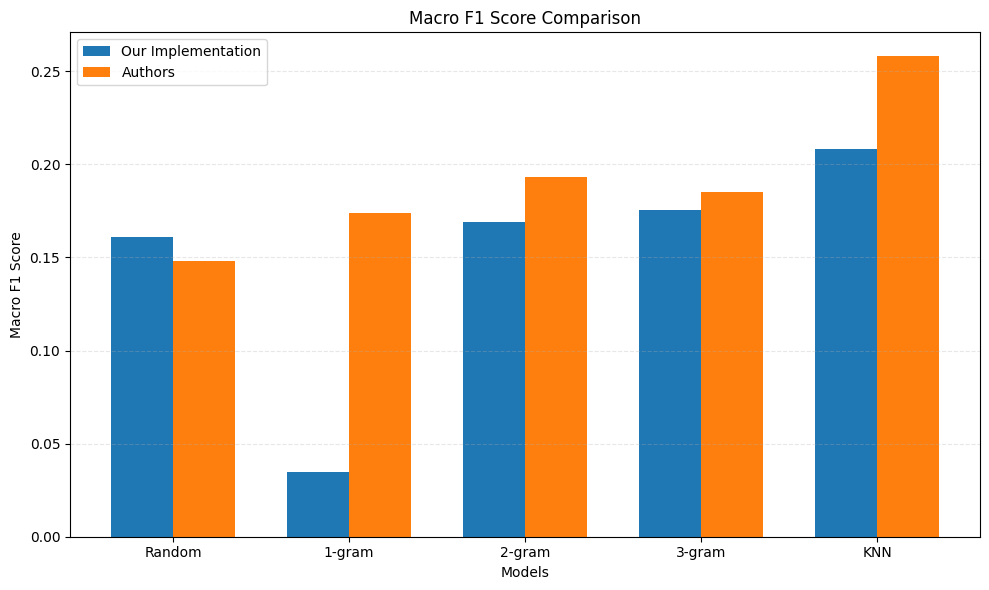

In [37]:
# Create visualization for Macro F1 Comparison
plt.figure(figsize=(10, 6))
models_list = list(models.keys())
our_f1_values = [models[model]['macro_f1'] for model in models_list]
authors_f1_values = [authors_results[model]['macro_f1'] for model in models_list]

x = np.arange(len(models_list))
width = 0.35

plt.bar(x - width/2, our_f1_values, width, label='Our Implementation')
plt.bar(x + width/2, authors_f1_values, width, label='Authors')

plt.xlabel('Models')
plt.ylabel('Macro F1 Score')
plt.title('Macro F1 Score Comparison')
plt.xticks(x, models_list)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'all_models_f1_comparison.png'))
plt.show()